<a href="https://colab.research.google.com/github/Hexin666666/gitskills/blob/main/unit13_cluster/demo3_newsgroup_with_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Newsgroup Clustering with LLM Embeddings

In the [newsgroup demo](./demo1_doc_cluster.ipynb) we showed how to cluster newsgroups by representing each text via a simple TF-IDF score.  In this demo, we will use a more sophisticated embedding using LLMs.  LLMs can provide a powerful pre-processor for a variety of text-related tasks.  In going through this demo, you will learn to:

* Download a simple, pre-trained LLM model from the Hugging Face platform
* Apply pre-trained LLM embeddings to a text corpus
* Use the LLM embeddings for a downstream task (in this case, clustering)

## Downloading the MiniLM model from Hugging Face

In this demo, we will use Microsoft's excellent [MiniLM model](https://github.com/microsoft/unilm/blob/master/minilm/README.md).  The MiniLM is a remarkably small model that you can run without a powerful GPU and still get decent performance.  For example, you can run the model on Google colab, even with a CPU only.    The MiniLM model is available on [Hugging Face](https://huggingface.co/).  Hugging Face is a widely-used online platform that provides tools and resources to help people build and share AI models, datasets, and applications.  You can use Hugging Face for your projects.  

To use the MiniLM model, we first install the `sentence-transformers` package that is part of [hugging Face](https://huggingface.co/sentence-transformers).


In [1]:
!pip install -U sentence-transformers


The mdoels in Hugging Face are mostly available in PyTorch, so we need to import `torch` to use them.  This demo will run faster if you enable the GPU.  If you are on Google Colab, you can select the GPU by following these [instructions](https://medium.com/@208r1a6734/how-to-connect-the-gpu-in-google-colab-5ff4cbd4b0a1).  But, if you only have a CPU, don't worry -- the demo will still work.

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Next, we download a `SentenceTransformer` model.  [Sentence transformers](https://huggingface.co/sentence-transformers) use LLMs to convert short text to an embedding, which is a numerical vector.  That numerical vector can then be the input for some subsequent neural network.  In this case, we download the miniLM sentence transformer.

In [3]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model = model.to(device)
embeddings = model.encode(sentences)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

We have applied the sentence transfomer two sentences.  If we look at the output we see it is of shape `(2,384)` since each sentnce was transformed to a 384 dimension vector.  The value 384 is called the *embedding dimension*.

In [4]:
print(embeddings.shape)

(2, 384)


## Applying the Sentence Transformer to the Newsgroup Dataset

We will now apply the sentence transformers to the classic newsgroup dataset.  As in the previous demo, we download four of the categories, but you could try this on more categories if you like.

In [7]:
import numpy as np

from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

In the resulting dataset:
* `dataset.data[i]` is the text for post `i`
* `dataset.target[i]` is the index of the class for the post
* `dataset.target_name[dataset.target[i]]` is the class name (e.g., `alt.atheism`)

Let's print an example post:


In [8]:
i = 10


print('Post from category ' + dataset.target_names[dataset.target[i]])
print('')
print(dataset.data[i])

Post from category comp.graphics


Hallo POV-Renderers !
I've got a BocaX3 Card. Now I try to get POV displaying True Colors
while rendering. I've tried most of the options and UNIVESA-Driver
but what happens isn't correct.
Can anybody help me ?



Next, we apply the LLM model to embed each of these posts to a vector.  This is the part that will be a bit faster with a GPU.  On Google Colab's T4 GPU, it will take about 30 seconds.  With a CPU about 5 minutes.

In [9]:
from tqdm import tqdm

text_emb = []
for text in tqdm(dataset.data):
    text_emb.append(model.encode(text))

100%|██████████| 3387/3387 [00:24<00:00, 140.21it/s]


Finally, we convert our embeddings to a numpy array.  Note the dimension is the number of samples `x` the embedding dimension.

In [10]:
text_emb = np.array(text_emb)
print(text_emb.shape)

(3387, 384)


## Running K-Means on the Text Embeddings

As a simple downstream task, let's run K-means on the text embeddings

In [11]:
## Run k-means on the text_emb
from sklearn.cluster import KMeans

num_clusters = 4
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(text_emb)
cluster_assignment = clustering_model.labels_

To compare the clustering by k-means with the newsgroup clusters, we count the number of each newsgroup cluster in each k-means cluster:
~~~
   C[i,j] = #posts in newsgroup cluster i and in k-means cluster j
~~~

In [12]:
# Find number of elements of true cluster are in each assigned cluster
true_clusters = dataset.target
ntrue = np.max(true_clusters) + 1
ncluster = np.max(cluster_assignment) + 1
C = np.zeros((ntrue, ncluster), dtype=int)
for i in range(ntrue):
  for j in range(ncluster):
    C[i,j] =  np.sum((true_clusters == i) & (cluster_assignment == j))

To print the results nicely, we will use a pandas dataframe.  Every time you run this program, you will get different results.  But, in general, you should see that the `sci.space` and `comp.graphics` get put mostly in clusters found by k-means.  But, the religon posts may be spread between two clusters.  

In [13]:
import pandas as pd
columns  = np.arange(ncluster)
df = pd.DataFrame(C, index=dataset.target_names, columns=columns)
df

,0,1,2,3
alt.atheism,28,588,4,179
comp.graphics,45,2,812,114
sci.space,779,25,30,153
talk.religion.misc,17,443,0,168


## Find documents with a similarity measure

One application of embeddings is that they can be used for finding documents matching some *query text*.  Specifically, we take a query text like:
~~~python
   query = 'This document is about computer graphics'
~~~
We can take the embedding of this query:
~~~
  query_emb = model.encode(query)
~~~
Then, we compute the **cosine similarity** between the query and text embeddings.
~~~
  R[i] = cosine_similarity(text_emb[i], query_emb)
~~~
where
~~~
  cosine_similarity(a,b) = a.dot(b)/||a||||b||
~~~
which is the cosine of the angle between the two vectors `a` and `b`.

We can perform a simple cosine similarity metric as follows:

In [17]:
query = ['This post is about computer graphics']
query_emb = model.encode(query)


# Find the cosine similarity between the targets and the text embeddings
from sklearn.metrics.pairwise import cosine_similarity
R = cosine_similarity(text_emb, query_emb)

# The shape will be (n,1) since there was only 1 query text
# We reshpe to size n
R = R[:,0]
print(R.shape)


(3387,)


Now we plot the CDF of the similarities of the posts in each cluster

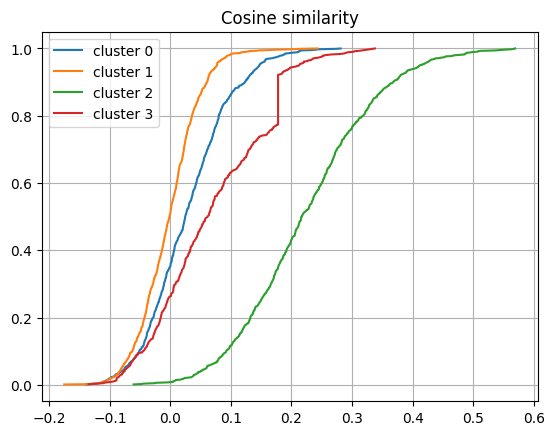

In [15]:
# PLot the CDF of the cosine similarity in each group # 上升的越慢相似度越高
import matplotlib.pyplot as plt
for i in range(num_clusters):
  ri = R[cluster_assignment == i]
  ri = np.sort(ri)
  ni = len(ri)
  p = np.arange(1, ni+1)/ni
  plt.plot(ri, p, label='cluster ' + str(i))
plt.legend()
title = 'Cosine similarity'
plt.title(title)
plt.grid()
plt.show()



Let's find the document with the highest similarity

In [16]:
imax = np.argmax(R)
print(dataset.target_names[dataset.target[imax]])
print(dataset.data[imax])

comp.graphics
Technion - Israel Institute of Technology
         Department of Computer Science

       GRADUATE STUDIES IN COMPUTER GRAPHICS

Applications are invited for graduate students wishing
to specialize in computer graphics and related fields.
Active research is being conducted in the fields of
image rendering, geometric modelling and computer animation.
State of the art graphics workstations (Sun, Silicon Graphics)
and video equipment are available.
The Technion offers full scholarship support (tuition and 
assistantships) for suitable candidates.

For more information contact
